This notebook contains the video data experiment results where we applied Neural NCPD to the video tensor. Due to the non-convexity of the NCPD task, results will vary run to run, so the results from this notebook will not exactly match those in the paper.

In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import os
import sys

sys.path.insert(1, "./src")
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor, Recon_Loss, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm

from lsqnonneg_module import LsqNonneg
from trainNNCPD import train

import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
w = 320
h = 180

## Generate Frames from Video

In [3]:
if(True):
    count = 0
    videoFile = "./data/nature_video.mp4"
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    #print(frameRate)
    #rameRate = 5
    x=1
    
    try:
        os.mkdir("./data/Images")
    except OSError:
        pass
    
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        frame = cv2.resize(frame, (w,h))
        if (frameId % math.floor(frameRate) == 0):
            filename ="./data/Images/frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

In [4]:
n = 37
X = np.zeros((n,h,w,3))

for i in range(n):
    im = plt.imread('./data/Images/frame' + str(i) + '.jpg')
    X[i,:,:,:] = im

In [5]:
X = X.reshape((n, -1,3)).transpose((0,2,1))

### Visualize first 36 Frames

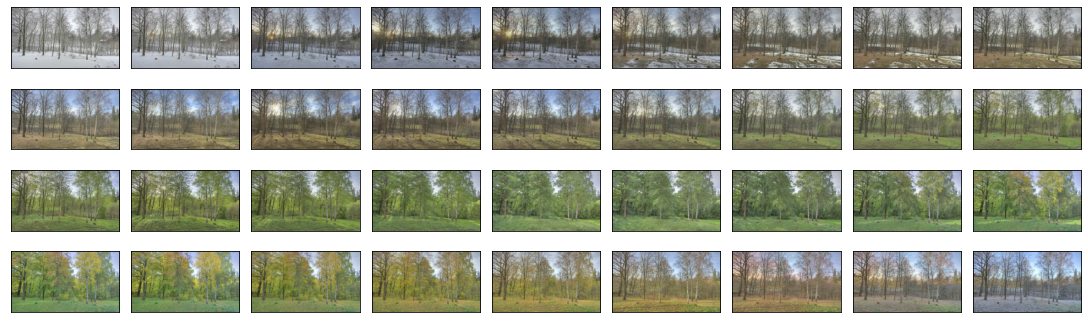

In [6]:
X_int = X.astype(int)
fig, axs = plt.subplots(4, 9, constrained_layout=True, figsize=(15,4.5))

for i in range(36):
    x = int(i/9)
    y = i%9
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])
    axs[x,y].imshow(X_int[i].reshape((3,h,w)).transpose((1,2,0)))

### Visualize a Samples of Frames, as in Paper

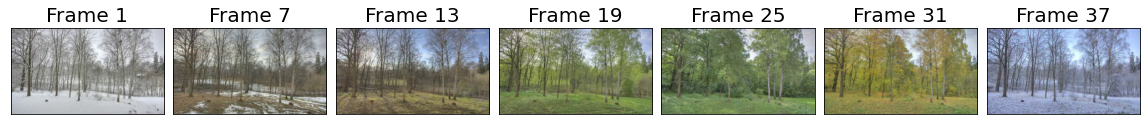

In [7]:
X_int = X.astype(int)
fig, axs = plt.subplots(1, 7, constrained_layout=False, figsize=(16,4.2))

for x, i in enumerate([1,7,13,19,25,31,37]):  
    i = i - 1
    axs[x].axes.xaxis.set_ticks([])
    axs[x].axes.yaxis.set_ticks([])
    axs[x].set_title("Frame " + str(i+1), fontsize=20)
    axs[x].imshow(X_int[i].reshape((3,h,w)).transpose((1,2,0)))
  
plt.subplots_adjust(left=0.125, bottom=0.1, right=2.769, top=0.9, wspace=0.001, hspace=0.035)
fig.tight_layout()
plt.show()

## Run Neural NCPD

In [8]:
X = torch.from_numpy(X)

r=8
n1,n2,n3 = X.shape
net = NNCPD([n1,6,3],[n2,6,3],[n3,6,3])

loss_func = Energy_Loss_Tensor()

history_unsupervised = train(net, X, loss_func, r, epoch = 1400, lr1 = 0, lr2 = 0.04, random_init=True)

/home/jvendrow/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


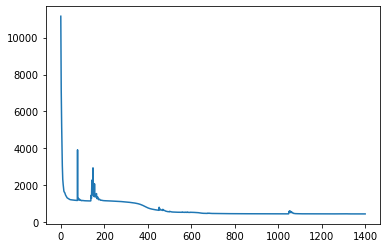

In [9]:
history_unsupervised.plot_scalar('loss')

In [10]:
#np.save("history_video_rank8_6_3_800_iters", history_unsupervised.tensor_dict)
X_1 = history_unsupervised.get('A_X1')[-1]
X_2 = history_unsupervised.get('B_X1')[-1]
X_3 = history_unsupervised.get('C_X1')[-1]

A_A1 = history_unsupervised.get('A_A1')[-1]
A_S1 = history_unsupervised.get('A_S1')[-1]
B_A1 = history_unsupervised.get('B_A1')[-1]
B_S1 = history_unsupervised.get('B_S1')[-1]
C_A1 = history_unsupervised.get('C_A1')[-1]
C_S1 = history_unsupervised.get('C_S1')[-1]

A_A2 = history_unsupervised.get('A_A2')[-1]
A_S2 = history_unsupervised.get('A_S2')[-1]
B_A2 = history_unsupervised.get('B_A2')[-1]
B_S2 = history_unsupervised.get('B_S2')[-1]
C_A2 = history_unsupervised.get('C_A2')[-1]
C_S2 = history_unsupervised.get('C_S2')[-1]

## Rank 8 Topics

### Rank 8 Spacial Mode

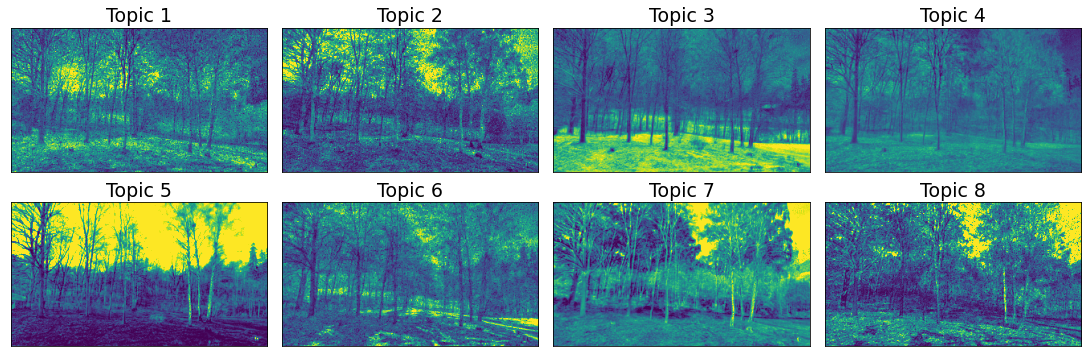

In [18]:
color = "viridis"
fig, axs = plt.subplots(2, 4, constrained_layout=True, figsize=(15,4.8))
for i in range(8):
    x = int(i/4)
    y = i%4
    axs[x][y].imshow(X_3[:,i].reshape(h,w)*70, cmap=plt.get_cmap(color), vmin=0, vmax=90)
    axs[x][y].set_title("Topic " + str(i+1), fontsize=19)
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])

### Rank 8 Temporal Mode

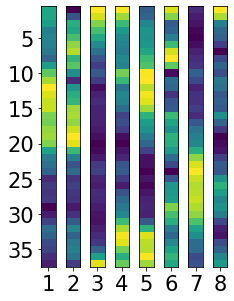

In [21]:
fig, axs = plt.subplots(1, 8, constrained_layout=True, figsize=(3.14,9))

X_1_normed = X_1 / np.linalg.norm(X_1, axis=0)

for i in range(8):

    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2),fontsize=21)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks([4,9,14,19,24,29,34], [5,10,15,20,25,30,35], fontsize=21)
    axs[i].imshow(X_1_normed[:,[i]], cmap=plt.get_cmap(color))
    
    ratio = 18
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

### Rank 8 Chromatic mode

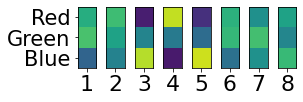

In [22]:
fig, axs = plt.subplots(1, 8, constrained_layout=True, figsize=(4.1,9))

X_2_normed = X_2 / np.linalg.norm(X_2, axis=0)

for i in range(8):
    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2), fontsize=22)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks(range(3), ['Red', 'Green', 'Blue'], fontsize=21)
    axs[i].imshow(X_2_normed[:,[i]], cmap=plt.get_cmap(color), vmin=0, vmax=1)
    
    ratio = 3.3
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)


plt.show()

## Rank 6 Topics

### Rank 6 Spacial Mode

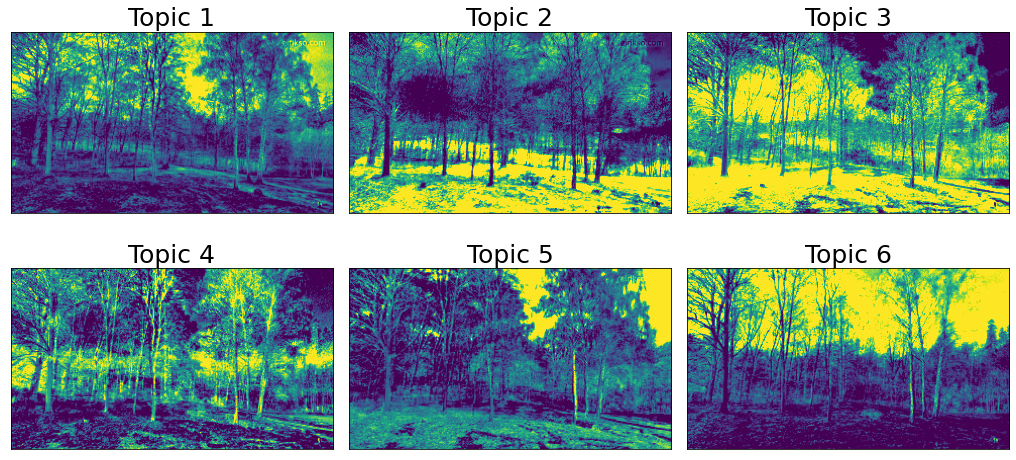

In [23]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(14,6.5))
for i in range(6):
    x = int(i/3)
    y = i%3
    axs[x][y].imshow(C_A1[:,i].reshape(h,w)*70, cmap=plt.get_cmap(color), vmin=0, vmax=160)
    axs[x][y].set_title("Topic " + str(i+1), fontsize=25)
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])

### Rank 6 Temporal Mode

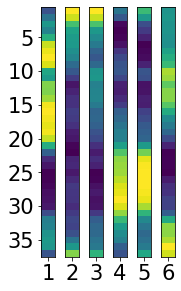

In [24]:
weight = weights_H(A_A1, B_A1, C_A1, A_S1, B_S1, C_S1)

fig, axs = plt.subplots(1, 6, constrained_layout=True, figsize=(2.41,9))

A_A1_new = A_A1 @ weight[:,:,0].T 
B_A1_new = B_A1 @ weight[:,:,1].T

A_A1_new = A_A1_new / np.linalg.norm(A_A1_new, axis=0)
B_A1_new = B_A1_new / np.linalg.norm(B_A1_new, axis=0)

for i in range(6):
    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2), fontsize=21)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks([4,9,14,19,24,29,34], [5,10,15,20,25,30,35], fontsize=21)
    axs[i].imshow(A_A1_new[:,[i]], cmap=plt.get_cmap(color))
    
    ratio = 18
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

### Rank 6 Chromatic Mode

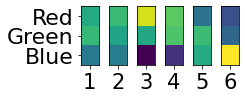

In [25]:
fig, axs = plt.subplots(1, 6, constrained_layout=True, figsize=(3.3,9))
color = "viridis"

B_A1_new = B_A1_new / np.linalg.norm(B_A1_new, axis=0)

for i in range(6):
    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2), fontsize=21)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks(range(3), ['Red', 'Green', 'Blue'], fontsize=22)
    axs[i].imshow(B_A1_new[:,[i]], cmap=plt.get_cmap(color), vmin=torch.min(B_A1_new), vmax=torch.max(B_A1_new))
    
    ratio = 3.3
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

## Rank 3 Results

### Rank 3 Spacial Mode

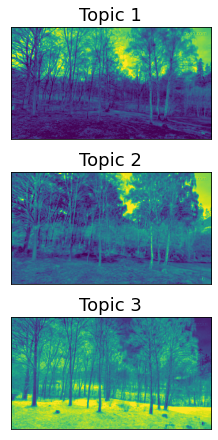

In [32]:
C2 = torch.mm(C_A1, C_A2)
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(6,6))
for i in range(3):
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].set_title("Topic " + str(i+1), fontsize=18)
    axs[i].imshow(C2[:,i].reshape(h,w)*70, vmin=0, vmax=900)

### Rank 3 Temporal Mode

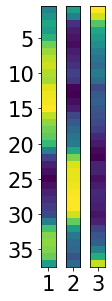

In [35]:
weight = weights_H(A_A1 @ A_A2, B_A1 @ B_A2, C_A1 @ C_A2, A_S2, B_S2, C_S2)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(1.44,9))
color = "viridis"

A2_new = (A_A1 @ A_A2) @ weight[:,:,0].T
A2_new = A2_new / np.linalg.norm(A2_new, axis=0)

for i in range(3):
    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2), fontsize=21)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks([4,9,14,19,24,29,34], [5,10,15,20,25,30,35], fontsize=21)
    axs[i].imshow(A2_new[:,[i]], cmap=plt.get_cmap(color))
    
    ratio = 18
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

### Rank 3 Chromatic Mode

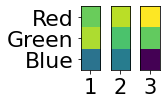

In [36]:
weight = weights_H(A_A1 @ A_A2, B_A1 @ B_A2, C_A1 @ C_A2, A_S2, B_S2, C_S2)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(2.2,9))
color = "viridis"

B2_new = (B_A1 @ B_A2) @ weight[:,:,1].T

B2_new = B2_new / np.linalg.norm(B2_new, axis=0)

for i in range(3):
    plt.sca(axs[i])
    plt.xticks(range(1), range(i+1,i+2), fontsize=21)
    if(i>0):
        axs[i].axes.yaxis.set_ticks([])
    else:
        plt.yticks(range(3), ['Red', 'Green', 'Blue'], fontsize=22)
    axs[i].imshow(B_A1_new[:,[i]], cmap=plt.get_cmap(color), vmin=torch.min(B2_new), vmax=torch.max(B2_new))
    
    ratio = 3.3
    ax = axs[i]
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

## S Matrices
Note that these S matrices will not look as nice as the S matrices in the paper. This is because the order of topics in NCPD is arbitrary, so to get a "nice" S matrix one needs to reorder the topics

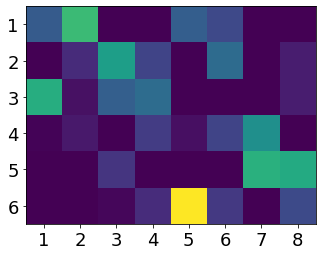

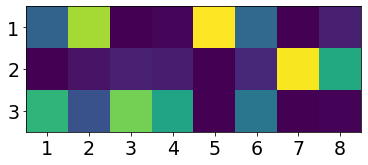

In [38]:
#S matrices

C_S1_normed = (C_S1.T * np.linalg.norm(C_A1, axis=0)).T

plt.xticks(range(0,8), range(1,9), fontsize=18)
plt.yticks(range(0,6), range(1,7), fontsize=18)
plt.imshow(C_S1_normed, cmap=plt.get_cmap(color))


plt.show()

plt.xticks(range(0,8), range(1,9), fontsize=19)
plt.yticks(range(0,3), range(1,4), fontsize=19)
C_S2_normed = (C_S2.T * np.linalg.norm(C2, axis=0)).T
plt.imshow(C_S2_normed, cmap=plt.get_cmap(color))

plt.show()